# 3. Feature Selection

In [1]:
# !pip install xgboost

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.feature_selection import RFE, chi2

In [3]:
# Load dataset
df = pd.read_csv('../data/heart_disease.csv')
X = df.drop('target', axis=1)
y = df['target']

In [4]:
rf = RandomForestClassifier(random_state=42)
rf.fit(X, y)

# Get feature importances
rf_importances = pd.Series(rf.feature_importances_, index=X.columns).sort_values(ascending=False)

In [5]:
xgb = XGBClassifier(random_state=42)
xgb.fit(X, y)

# Get feature importances
xgb_importances = pd.Series(xgb.feature_importances_, index=X.columns).sort_values(ascending=False)

C:\Users\windows10\AppData\Local\Temp\ipykernel_3060\3684021497.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=rf_importances.values, y=rf_importances.index, palette='viridis')
C:\Users\windows10\AppData\Local\Temp\ipykernel_3060\3684021497.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=xgb_importances.values, y=xgb_importances.index, palette='viridis')


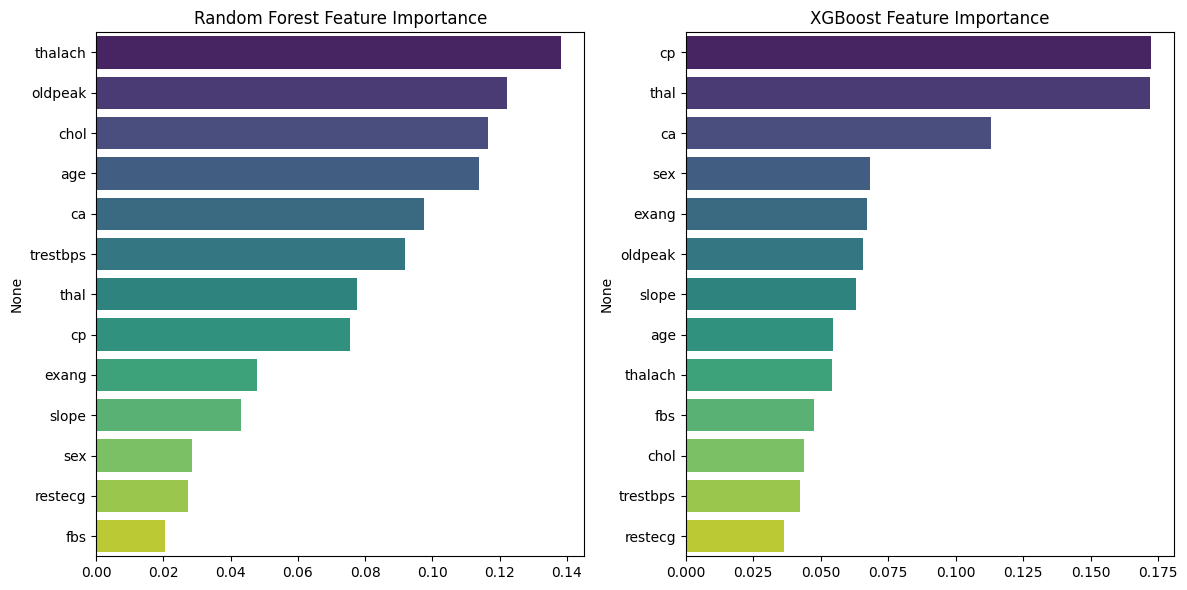

In [6]:
plt.figure(figsize=(12, 6))

# Random Forest Importance
plt.subplot(1, 2, 1)
sns.barplot(x=rf_importances.values, y=rf_importances.index, palette='viridis')
plt.title('Random Forest Feature Importance')

# XGBoost Importance
plt.subplot(1, 2, 2)
sns.barplot(x=xgb_importances.values, y=xgb_importances.index, palette='viridis')
plt.title('XGBoost Feature Importance')

plt.tight_layout()
plt.show()

RFE Selected Features: ['age', 'trestbps', 'chol', 'thalach', 'oldpeak']


C:\Users\windows10\AppData\Local\Temp\ipykernel_3060\2700023448.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=rfe_rankings.sort_values().values, y=rfe_rankings.sort_values().index, palette='viridis')


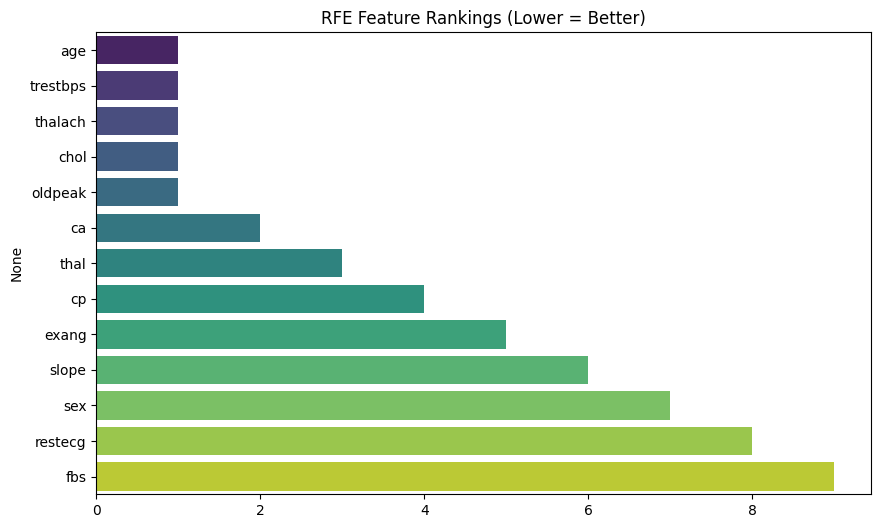

In [7]:
# Use RandomForest as the estimator for RFE
rfe = RFE(estimator=RandomForestClassifier(random_state=42), n_features_to_select=5)
rfe.fit(X, y)

selected_features = X.columns[rfe.support_]
print("RFE Selected Features:", selected_features.tolist())

rfe_rankings = pd.Series(rfe.ranking_, index=X.columns)
plt.figure(figsize=(10, 6))
sns.barplot(x=rfe_rankings.sort_values().values, y=rfe_rankings.sort_values().index, palette='viridis')
plt.title('RFE Feature Rankings (Lower = Better)')
plt.show()

C:\Users\windows10\AppData\Local\Temp\ipykernel_3060\2979319970.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='p-value', y='Feature', data=chi_df, palette='viridis')


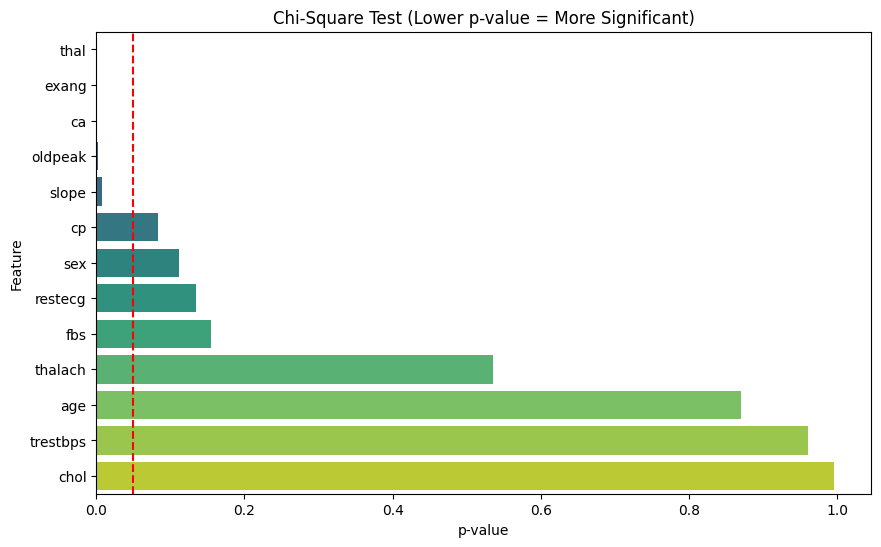

Significant Features (Chi-Square): ['thal', 'exang', 'ca', 'oldpeak', 'slope']


In [8]:
# Normalize data
X_normalized = MinMaxScaler().fit_transform(X)

# Compute Chi-Square scores
chi_scores, p_values = chi2(X_normalized, y)

# Plot p-values
chi_df = pd.DataFrame({'Feature': X.columns, 'p-value': p_values}).sort_values('p-value')
plt.figure(figsize=(10, 6))
sns.barplot(x='p-value', y='Feature', data=chi_df, palette='viridis')
plt.axvline(x=0.05, color='red', linestyle='--', label='p=0.05')
plt.title('Chi-Square Test (Lower p-value = More Significant)')
plt.show()

# Significant features (p < 0.05)
significant_features = chi_df[chi_df['p-value'] < 0.05]['Feature'].tolist()
print("Significant Features (Chi-Square):", significant_features)

In [9]:
feature_scores = pd.DataFrame(index=X.columns)

# Add scores from each method
feature_scores['RF_importance'] = rf_importances
feature_scores['XGB_importance'] = xgb_importances
feature_scores['RFE_ranking'] = rfe_rankings
feature_scores['Chi_pvalue'] = p_values

# Normalize scores (0-1)
feature_scores['RF_score'] = feature_scores['RF_importance'] / feature_scores['RF_importance'].max()
feature_scores['XGB_score'] = feature_scores['XGB_importance'] / feature_scores['XGB_importance'].max()
feature_scores['RFE_score'] = 1 - (feature_scores['RFE_ranking'] / feature_scores['RFE_ranking'].max())
feature_scores['Chi_score'] = 1 - (feature_scores['Chi_pvalue'] / feature_scores['Chi_pvalue'].max())

# Combined score (weighted average)
feature_scores['Combined_score'] = (
    feature_scores['RF_score'] * 0.3 +
    feature_scores['XGB_score'] * 0.3 +
    feature_scores['RFE_score'] * 0.2 +
    feature_scores['Chi_score'] * 0.2
)

# Select top 7 features
top_features = feature_scores.sort_values('Combined_score', ascending=False).head(7).index.tolist()
print("\nTop Selected Features:", top_features)


Top Selected Features: ['thal', 'ca', 'cp', 'oldpeak', 'thalach', 'age', 'exang']


In [10]:
X_reduced = X[top_features]
print("\nReduced Dataset Shape:", X_reduced.shape)


Reduced Dataset Shape: (303, 7)


In [12]:
X_reduced

,thal,ca,cp,oldpeak,thalach,age,exang
0,6.0,0.0,1,0.370968,0.603053,0.708333,0
1,3.0,3.0,4,0.241935,0.282443,0.791667,1
2,7.0,2.0,4,0.419355,0.442748,0.791667,1
3,3.0,0.0,3,0.564516,0.885496,0.166667,0
4,3.0,0.0,2,0.225806,0.770992,0.250000,0
...,...,...,...,...,...,...,...
298,7.0,0.0,1,0.193548,0.465649,0.333333,0
299,7.0,2.0,4,0.548387,0.534351,0.812500,0
300,7.0,1.0,4,0.193548,0.335878,0.583333,1
301,3.0,1.0,2,0.000000,0.786260,0.583333,0


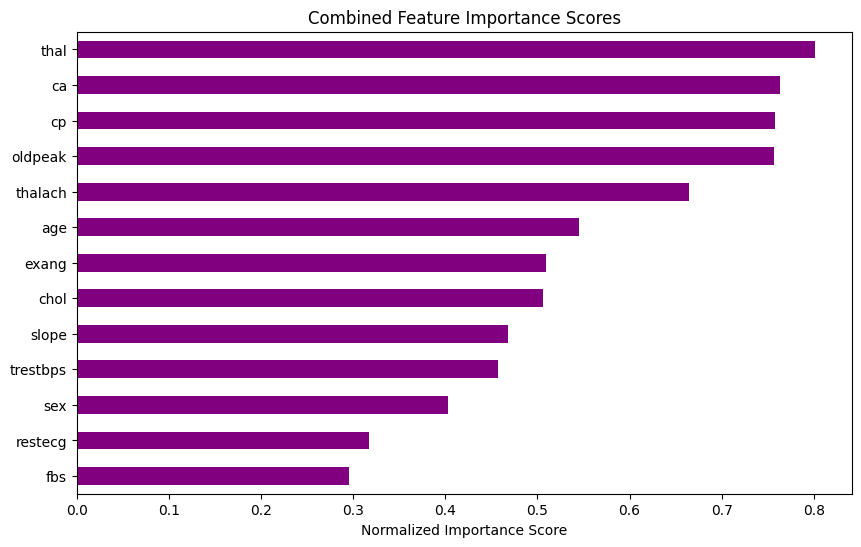

In [13]:
plt.figure(figsize=(10, 6))
feature_scores.sort_values('Combined_score')['Combined_score'].plot(kind='barh', color='purple')
plt.title('Combined Feature Importance Scores')
plt.xlabel('Normalized Importance Score')
plt.show()

In [14]:
new_data_frame = pd.DataFrame(X_reduced)
new_data_frame['target'] = y
new_data_frame

,thal,ca,cp,oldpeak,thalach,age,exang,target
0,6.0,0.0,1,0.370968,0.603053,0.708333,0,0
1,3.0,3.0,4,0.241935,0.282443,0.791667,1,2
2,7.0,2.0,4,0.419355,0.442748,0.791667,1,1
3,3.0,0.0,3,0.564516,0.885496,0.166667,0,0
4,3.0,0.0,2,0.225806,0.770992,0.250000,0,0
...,...,...,...,...,...,...,...,...
298,7.0,0.0,1,0.193548,0.465649,0.333333,0,1
299,7.0,2.0,4,0.548387,0.534351,0.812500,0,2
300,7.0,1.0,4,0.193548,0.335878,0.583333,1,3
301,3.0,1.0,2,0.000000,0.786260,0.583333,0,1


In [16]:
new_data_frame.to_csv('../data/heart_disease.csv', index=False)